Introduction
--------------

**Ultrasound Signal Processing**

Ultrasound signals are also called ultrasound RF signals because of the frequencies that they carry. The main frequency is the one of the ultrasound transducer or resonator that is used to generate the acoustic wave and to receive the same wave that is reflected by tissues.

An ultrasound signal needs to be processed to obtain imaging information. The steps for forming an image in ultrasound are:

1. Generate an ultrasound mechanical/acoustical wave with the transducer which is usually done by exciting electrically this transducer using a pulser (square electrical pulse of about 900V peak and short duration)
2. Receive and digitize the ultrasound mechanical/acoustical wave by the transducer which is done by receiving the electrical signal from the transducer using a receiver (usually on the same like as the pulser, thus this device is commonly known as a pulser/receiver)
3. The recieved and later digitized signal will have a main frequency that is the central frequency of the transducer material used to generate the ultrasound wave, usually between 1 and 10 MHz
4. The signal is often digitized after limitation and then amplification:

   a. Limitation is performed to eliminate the large voltage pulse sent to the transducer (the received signal is in the order of 2mV while the pulse is 900V)
   
   b. Amplification is performed after limitation and it requires usually about 40dB in gain to boost the signal to values required by most acquisition cards (around 2V)

5. After acquisition we need to compensate for attenuation

6. We finally require to obtain the intensity of each pixel by the envelope of the signal

7. We repeat for all lines

We will open and analyse the signal acquired from a pulser/receiver which was digitized by a 12-bit acquisition card sampling at $125 MHz$ with a $2 Vpp$ maximum voltage. The file provided has one single line coming from this pulser/receiver and it is stored in the file $SingleUSSignalI.dat$. The data in this file was stored by the acquisition card as unsigned integers of 16 bits.

We will first plot the signal with the time scale:

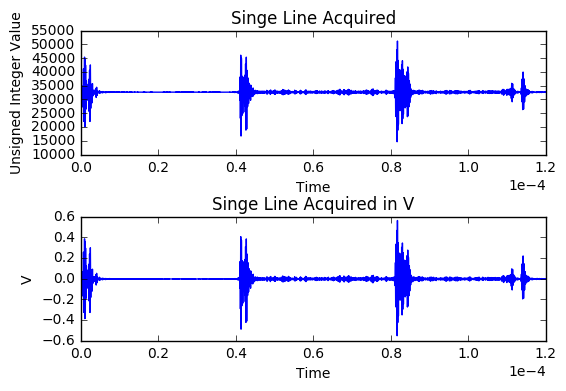

In [9]:
#we have first this command that initialize and matplotlib (library) for plotting and we specify that we want those plots inline in this notebook
%matplotlib inline

#now we import different packages that will allow to do math, lineal algebra, numerical operations, array operations and plotting
import scipy as Sci
import scipy.linalg
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from scipy.signal import hilbert

#we use a simple open command for the file (basic Python)
f = open('SingleUSSignalI.dat','rb')   # Windows
#we read it using a numpy (therefore the np.) command that allows direct reading from file into an array
Line = np.fromfile(f,count=-1,dtype=np.uint16)
L=len(Line)
f.close() #close the file
#we will now populate an array for the time which we now is 1/125MHz step for a total of 15000
x=np.arange(0,L/125e6,1/125e6)  #start,stop,step
#now we plot only the first line acquired (15000 samples)
plt.subplots_adjust( hspace = .5 )
plt.subplot(211)
plt.plot(x,Line[:L])
plt.title('Singe Line Acquired')
plt.xlabel('Time')
plt.ylabel('Unsigned Integer Value')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#But this is in integers, in volts we need to calculate 2Vpp -> 65535=1V and 0=-1V
LineF=Line.astype(np.float64)
LineF/=(2**15-1)
LineF-=1.
plt.subplot(212)
plt.plot(x,LineF[:L])
plt.title('Singe Line Acquired in V')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

We will analyze this signal visually (zoom) to estimate the frequency of the transducer used.

We will then perform a Fourier transform to obtain the central frequency of the transducer.

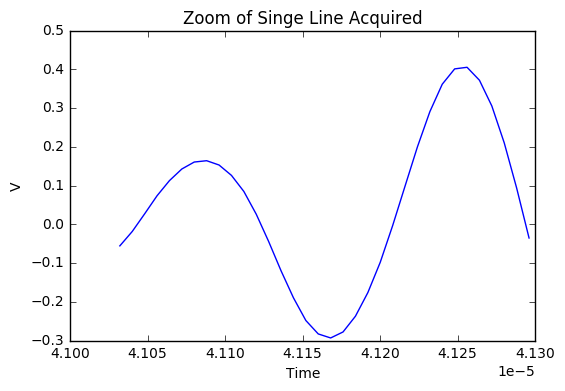

In [10]:
inx1=np.where(x>0.4103e-4)
inx1=inx1[0]
inx2=np.where(x>0.413e-4)
inx2=inx2[0]
plt.plot(x[inx1[0]:inx2[0]],LineF[inx1[0]:inx2[0]])
plt.title('Zoom of Singe Line Acquired')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

Since 1.5 cycles of the signal are between $0.4103e-4$ and $0.413e-4$ we then have a frequency of $\frac{1}{(0.413\times 10^{-4}-0.4103\times 10^{-4})/1.5}=5.5MHz$

We will now obtain this using DFT. Note: just as we did before, we will take away the dc component!

The maximum is 0.004006 and it is found at index 596 which is the frequency 4.966667e+06


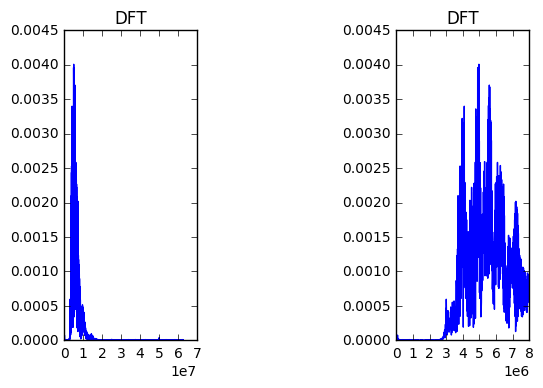

In [11]:
#Eliminating dc
LineF-=np.mean(LineF)
#Now let's obtain the spectrum
#the frequencies after fft will be between 0 and 1/2 of the sampling frequency
f=np.arange(0,125e6/2,125e6/L)
Y=np.fft.fft(LineF)
Pyy=abs(Y)/L
#note: we are showing just L/2 elements which are the positive frequencies and we are normalizing

#preparing the plotting
plt.subplots_adjust( wspace = 1.5 )
plt.subplot(121)
L2=len(Pyy)/2

plt.plot(f[:L2], Pyy[:L2])
plt.title('DFT')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#Zooming into just less than 8MHz
inx=np.where(f>8e6)
inx=inx[0]
plt.subplot(122)
plt.plot(f[:inx[0]], Pyy[:inx[0]])
plt.title('DFT')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#Let's obtain the frequency at which the maximum is observed
#Remember we have a DFT which is mirrored, so we only work with half
PyyM=Pyy[:L2]
mm=np.argmax(PyyM) #this gives the index where the max is found
print("The maximum is %f and it is found at index %d which is the frequency %e" % (max(PyyM),mm,f[mm]))

We can see that the frequency of that transducer is $4.96MHz$ and as you can see, using the DFT gave us more precision than estimation.

Assuming that the tissues have attenuated this signal $4Np/m/MHz$ we will compensate for this attenuation and plot the real time-gain-compensated signal. The attenuation is exponential so we can compensate using:

$$ RF_{com}=RF e^{\mu d}\;\;\mu=\alpha f\;\;\;\;\;d=ct\;\;\;c\approx 1450m/s$$


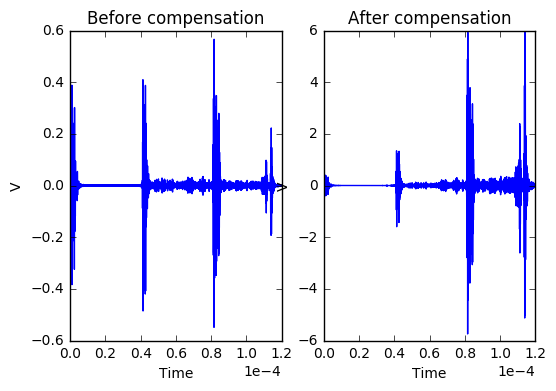

In [12]:
#Compensating
h=x*1450
ffatt=np.exp(4*4.96*h)
LineC=LineF*ffatt
#Plotting
plt.subplot(121)
plt.plot(x,LineF[:L])
plt.title('Before compensation')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(122)
plt.plot(x,LineC[:L])
plt.title('After compensation')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

To prepare for forming an image, we will now obtain the envelope of the signal and plot. This is done using a Hilbert transform.

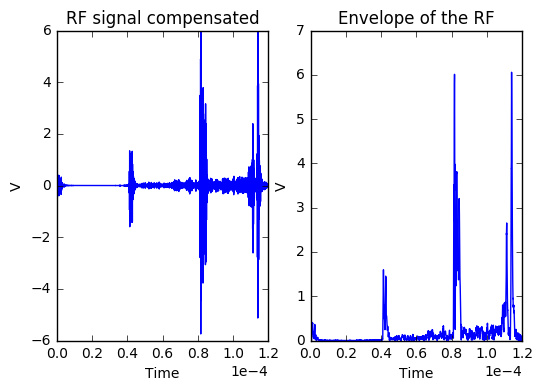

In [13]:
#Hilbert Transform
LineE=hilbert(LineC)
LineE=abs(LineE)
#Plotting
plt.subplot(121)
plt.plot(x,LineC[:L])
plt.title('RF signal compensated')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(122)
plt.plot(x,LineE[:L])
plt.title('Envelope of the RF')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

**Ultrasound Imaging Processing**

We can obtain an image by repeating all those operations this time on multiple lines RF. Using the file $MultipleUSSignalsI.dat$ with the same format as before we will obtain the image.


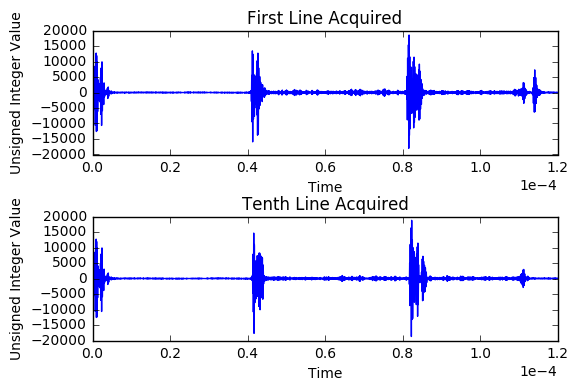

In [14]:
#we use a simple open command for the file (basic Python)
f = open('MultipleUSSignalsI.dat','rb')   # Windows
#we read it using a numpy (therefore the np.) command that allows direct reading from file into an array
Lines = np.fromfile(f,count=-1,dtype=np.uint16)
f.close() #close the file
#we will now populate a 2D matrix for the lines
TL=len(Lines)/L
Lines=Lines-np.mean(Lines)
LinesRF=Lines.reshape(TL,L,order='F').copy()  #columns,rows
#now we plot two lines acquired to double check (15000 samples)
plt.subplots_adjust( hspace = .5 )
plt.subplot(211)
plt.plot(x,LinesRF[0][:L]) #first line
plt.title('First Line Acquired')
plt.xlabel('Time')
plt.ylabel('Unsigned Integer Value')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(212)
plt.plot(x,LinesRF[10][:L]) #10th line
plt.title('Tenth Line Acquired')
plt.xlabel('Time')
plt.ylabel('Unsigned Integer Value')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

We will now compensate attenuation and apply the Hilbert transform to all the 2D array.

And we can then create the image (it should be logarithmic).



b) Use the program in Matlab to obtain the image (sonogram\_dBAssignment)\\
c) Answer the questions in comments on sonogram\_dBAssignment \\
 1: What is the meaning of dB imaging here?
 2: Is there any filtering done in the image? where? which filter? how does it work and why was this filtering chosen?
 3: Describe the general procedure in blocks 
 4: Add attenuation compensation to this function, assume attenuation of $4Np/m/MHz$; explain how it works
d) Show your image and the code modifications\\
e) What function is used to obtain the envelope and why?\\



If we notice the signal has a dc component (not centered in zero) so unless we want to have a spectrum with a large value of dc or zero frequency we will first remove the dc component (by substracting the mean of the data).

We will then obtain the DFT.


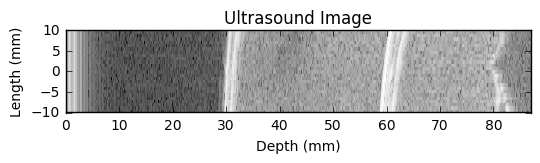

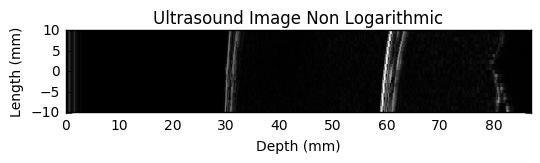

In [15]:
#Compensating
h=x*1450
ffatt=np.exp(2*4.96*h)
LinesRFC=LinesRF*ffatt
LinesRFE=hilbert(LinesRFC)
LinesRFE=abs(LinesRFE)

#images need to be logarithmic so we can see all the contrast
Mx=LinesRFE.max()
Image=20*np.log10(LinesRFE/Mx)
ImageBW=LinesRFE

#the line axis
s=np.linspace(-10,10,26)
#Plotting
d=h/2*1000  #answer: why are we doing this here?
plt.figure()
plt.set_cmap(plt.gray()) #grayscale
plt.pcolormesh(d, s, Image[:, :])
plt.axis([d.min(),d.max(),s.min(),s.max()])
plt.axes().set_aspect(10./13)  #this is because I know the image was 20mm in lenght so 26 lines=20mm or a ratio 10/13
plt.title('Ultrasound Image')
plt.xlabel('Depth (mm)')
plt.ylabel('Length (mm)')

plt.figure()
plt.set_cmap(plt.gray()) #grayscale
plt.pcolormesh(d, s, ImageBW[:, :])
plt.axis([d.min(),d.max(),s.min(),s.max()])
plt.axes().set_aspect(10./13)
plt.title('Ultrasound Image Non Logarithmic')
plt.xlabel('Depth (mm)')
plt.ylabel('Length (mm)')

We will finally apply one of the most common filters that are used in ultrasound imaging: the median filter. This will make the image less "grainy" to the user.
We will also implement a usual "cutoff" in the displayed image, anything less than -60dB will be eliminated.

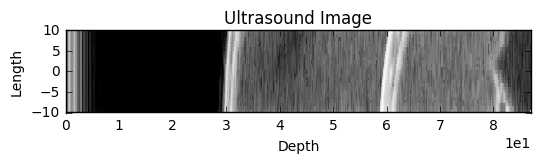

In [16]:
from scipy.signal import medfilt

#we cut anything below -60dB
cutdb=-60
inx=np.where(Image<cutdb)
Image[inx]=cutdb

#and we filter using a 5x5 median filter
ImageF=medfilt(Image,5)

#Plotting
d=h/2*1000
plt.figure()
plt.set_cmap(plt.gray()) #grayscale
plt.pcolormesh(d, s, ImageF[:, :])
plt.axis([d.min(),d.max(),s.min(),s.max()])
plt.axes().set_aspect(10./13)
plt.title('Ultrasound Image')
plt.xlabel('Depth')
plt.ylabel('Length')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


## Summary

In this example, we rendered an ultrasound image from RF signals acquired with a pulser/receiver.

Your work to do is:

* Find out and discuss the effect of modifying the filter and explain briefly in a sentence or two (insert in the Markdown) how a median filter works.
* Modify the code on the image part so that we work with real voltages (follow the example at the beginning) and answer: do you expect this to change any of the aspect in your image? why not? Insert this discussion in the Markdown
* Don't forget to send me the link to your notebook once you have it finalized!

Comments and corrections welcome!

References
---------------

* Oppenheim, A. V., and A. S. Willsky. "Signals and Systems." Prentice-Hall, (1997).